## Autoencoder + Classifier for MNIST dataset

In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader 

import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

from torchvision import datasets, models, transforms     # vision datasets,
                                                         # architectures &
                                                         # transforms
from torchvision.utils import save_image
import torchvision.transforms as transforms              # composable transforms

In [2]:
import os
if not os.path.exists('./ae_v2_img'):
    os.mkdir('./ae_v2_img')
import numpy as np

In [3]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5])])

full_trainset = datasets.MNIST(root='./data', train=True, transform=transform, target_transform=None, download=True)

len_train = int(0.8 * len(full_trainset))
len_val = len(full_trainset) - len_train

train_set, val_set = torch.utils.data.random_split(full_trainset, [len_train, len_val]) 

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = datasets.MNIST(root='./data', train=False, transform=transform, target_transform=None, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [6]:
len(train_set)

48000

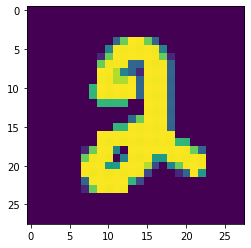

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

images, labels = iter(train_loader).next()
img = images[0][0].numpy()
plt.imshow(img)

In [8]:
class Network(nn.Module):
    def __init__(self, bottleneck = 8):
        super(Network, self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(784, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 16), 
                                    nn.ReLU(),
                                    nn.Linear(16, bottleneck),
                                    nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Linear(bottleneck, 16),
                                    nn.ReLU(),
                                    nn.Linear(16, 32),
                                    nn.ReLU(),
                                    nn.Linear(32, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 784),
                                    nn.Tanh())
        
        self.classifier = nn.Sequential(nn.Linear(bottleneck, 64),
                                        nn.ReLU(),
                                        nn.Linear(64, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 10),
                                        nn.LogSoftmax(dim=1))
        self.config = "decoder"
        
    def forward(self, x,):
        encoded = self.encoder(x)
        if self.config=="decoder":
            out = self.decoder(encoded)
        elif self.config=="classifier":
            out = self.classifier(encoded)
        else:
            print("error")
            return
        
        return out
        

In [9]:
model = Network()

In [10]:
for param in model.classifier.parameters():
    param.requires_grad = False

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
val_loss_min = np.Inf

for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    model.train()
    for image, label in train_loader:
        image = image.view(image.size(0), -1)
        #forward
        out = model(image)
        loss = criterion(out, image)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*image.size(0)
    
    train_loss = train_loss/len(train_loader)
    
    if epoch % 10 == 0:
        rep_pic = to_img(out)
        save_image(rep_pic, './ae_v2_img/rep_image_{}.png'.format(epoch)) 
        original_pic = to_img(image)
        save_image(original_pic,'./ae_v2_img/ori_image_{}.png'.format(epoch))
        
    model.eval()
    for image, label in val_loader:
        image = image.view(image.size(0), -1)
        out = model(image)
        loss = criterion(out, image)

        val_loss += loss.item()*image.size(0)
        
    val_loss = val_loss/len(val_loader)
    
    print('epoch [{}/{}], \tTraining Loss:{:.4f} \tValidation Loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    
    if val_loss < val_loss_min:
        print('Validation loss has decreased ({:.4f}-->{:.4f}). Model saved...'.format(val_loss_min, val_loss))
        torch.save(model.state_dict(), 'autoencoder_V2.pt')
        val_loss_min = val_loss

epoch [1/100], 	Training Loss:34.1727 	Validation Loss:26.7879
Validation loss has decreased (inf-->26.7879). Model saved...
epoch [2/100], 	Training Loss:22.6031 	Validation Loss:19.8073
Validation loss has decreased (26.7879-->19.8073). Model saved...
epoch [3/100], 	Training Loss:18.8241 	Validation Loss:18.1555
Validation loss has decreased (19.8073-->18.1555). Model saved...
epoch [4/100], 	Training Loss:17.2469 	Validation Loss:16.5161
Validation loss has decreased (18.1555-->16.5161). Model saved...
epoch [5/100], 	Training Loss:15.9202 	Validation Loss:15.6468
Validation loss has decreased (16.5161-->15.6468). Model saved...
epoch [6/100], 	Training Loss:15.2455 	Validation Loss:15.1638
Validation loss has decreased (15.6468-->15.1638). Model saved...
epoch [7/100], 	Training Loss:14.8267 	Validation Loss:14.8243
Validation loss has decreased (15.1638-->14.8243). Model saved...
epoch [8/100], 	Training Loss:14.5097 	Validation Loss:14.4982
Validation loss has decreased (14.8243

epoch [73/100], 	Training Loss:9.6515 	Validation Loss:9.9708
epoch [74/100], 	Training Loss:9.6559 	Validation Loss:9.9460
Validation loss has decreased (9.9472-->9.9460). Model saved...
epoch [75/100], 	Training Loss:9.6328 	Validation Loss:9.9224
Validation loss has decreased (9.9460-->9.9224). Model saved...
epoch [76/100], 	Training Loss:9.6351 	Validation Loss:9.9389
epoch [77/100], 	Training Loss:9.6069 	Validation Loss:9.8968
Validation loss has decreased (9.9224-->9.8968). Model saved...
epoch [78/100], 	Training Loss:9.6049 	Validation Loss:9.9262
epoch [79/100], 	Training Loss:9.5882 	Validation Loss:9.9472
epoch [80/100], 	Training Loss:9.5831 	Validation Loss:9.8822
Validation loss has decreased (9.8968-->9.8822). Model saved...
epoch [81/100], 	Training Loss:9.5783 	Validation Loss:9.9104
epoch [82/100], 	Training Loss:9.5514 	Validation Loss:9.8738
Validation loss has decreased (9.8822-->9.8738). Model saved...
epoch [83/100], 	Training Loss:9.5613 	Validation Loss:9.864

In [13]:
for param in model.classifier.parameters():
    param.requires_grad = True

In [14]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [15]:
for param in model.decoder.parameters():
    param.requires_grad = False

In [16]:
model.config = "classifier"

In [17]:
criterion = nn.NLLLoss()

In [18]:
num_epochs = 50

In [20]:
val_loss_min = np.Inf
train_loss_arr = []
val_loss_arr=[]
for epoch in range(num_epochs):
    
    train_loss = 0
    val_loss = 0
    
    model.train()
    
    for image, label in train_loader:
        image = image.view(image.size(0), -1)
        #forward
        out = model(image)
        loss = criterion(out, label)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*image.size(0)
        
    model.eval()
    
    for image, label in val_loader:
        image = image.view(image.size(0), -1)
        out = model(image)
        loss = criterion(out, label)
        
        val_loss += loss.item()*image.size(0)
    
    val_loss = val_loss/len(val_loader)    
    train_loss = train_loss/len(train_loader)
    
    val_loss_arr.append(val_loss)
    train_loss_arr.append(train_loss)
    
    print('epoch [{}/{}], \tTraining Loss:{:.4f} \tValidation Loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    
    if val_loss < val_loss_min:
        print('Validation loss has decreased ({:.4f}-->{:.4f}). Model saved...'.format(val_loss_min, val_loss))
        torch.save(model.state_dict(), 'autoencoder_V2.pt')
        val_loss_min = val_loss
    

epoch [1/50], 	Training Loss:40.6486 	Validation Loss:42.2037
Validation loss has decreased (inf-->42.2037). Model saved...
epoch [2/50], 	Training Loss:39.4006 	Validation Loss:38.7358
Validation loss has decreased (42.2037-->38.7358). Model saved...
epoch [3/50], 	Training Loss:38.3902 	Validation Loss:37.5642
Validation loss has decreased (38.7358-->37.5642). Model saved...
epoch [4/50], 	Training Loss:37.4150 	Validation Loss:39.3014
epoch [5/50], 	Training Loss:36.8802 	Validation Loss:37.0484
Validation loss has decreased (37.5642-->37.0484). Model saved...
epoch [6/50], 	Training Loss:36.0556 	Validation Loss:35.9903
Validation loss has decreased (37.0484-->35.9903). Model saved...
epoch [7/50], 	Training Loss:35.4909 	Validation Loss:35.2170
Validation loss has decreased (35.9903-->35.2170). Model saved...
epoch [8/50], 	Training Loss:35.0196 	Validation Loss:35.3482
epoch [9/50], 	Training Loss:34.3218 	Validation Loss:34.9070
Validation loss has decreased (35.2170-->34.9070).

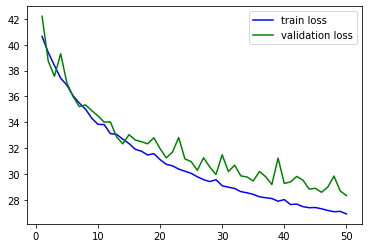

In [23]:
arr_x = list(range(1, num_epochs+1))
plt.plot(arr_x, train_loss_arr, 'b-', label='train loss')
plt.plot(arr_x, val_loss_arr, 'g-', label='validation loss')
plt.legend(loc='upper right')
plt.show()

In [24]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for image, target in test_loader:
    image = image.view(image.size(0), -1)
    output = model(image)
    loss = criterion(output, target)

    test_loss += loss.item()*image.size(0)

    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.231017

Test Accuracy of     0: 97% (957/980)
Test Accuracy of     1: 98% (1116/1135)
Test Accuracy of     2: 93% (970/1032)
Test Accuracy of     3: 93% (941/1010)
Test Accuracy of     4: 91% (903/982)
Test Accuracy of     5: 86% (772/892)
Test Accuracy of     6: 96% (922/958)
Test Accuracy of     7: 94% (968/1028)
Test Accuracy of     8: 91% (887/974)
Test Accuracy of     9: 85% (863/1009)

Test Accuracy (Overall): 92% (9299/10000)


## Future Experiments
<ul>
    <li>Compare both models efficiency in clustering</li>
</ul>